<a href="https://colab.research.google.com/github/DmitryKutsev/NIS_SentiFrame/blob/master/skipgram_research_18_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install pymorphy2[fast]

In [0]:
import os
import gensim
from collections import Counter
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from sklearn.metrics.pairwise import cosine_similarity
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [0]:
# # !wget https://raw.githubusercontent.com/nicolay-r/RuSentiFrames/master/collection.json
# with open("collection.json", "r", encoding="utf-8") as f:
#   collection = json.load(f)
# # !rm collection.json

In [0]:
%%capture
# taiga model
!wget http://vectors.nlpl.eu/repository/20/185.zip

In [6]:
import zipfile
model_url = 'http://vectors.nlpl.eu/repository/20/185.zip'
# m = wget.download(model_url)
model_file = model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    skipgram_model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def make_seed_embedding(seed_dict, model):
  '''
  Принимает на вход список, на выходе дает средний вектор всех слов из этого списка
  '''
  summ = 0
  if model == skipgram_model:
    for verb in seed_dict:
      summ = summ + model[verb + '_VERB']
    return summ/len(seed_dict)

#Axis approach

In [0]:
def compare2axis(word_list, 
                 positive_seed_list, negative_seed_list, 
                 model=skipgram_model):
    p_seed_emb = make_seed_embedding(positive_seed_list, model=model)
    n_seed_emb = make_seed_embedding(negative_seed_list, model=model)
    seed_axis = p_seed_emb - n_seed_emb
    return cosine_similarity(
        np.atleast_2d(make_seed_embedding(word_list, model=model)), 
        np.atleast_2d(seed_axis))[0][0]

In [0]:
def percentage(pddf, less_than=True, threshold=0.2):
    total = len(pddf)
    if less_than:
        return len(pddf[(pddf['skipgram_axis_similarity']<threshold)])/total
    else:
        return len(pddf[(pddf['skipgram_axis_similarity']>threshold)])/total

def draw_bars(pd_df, threshold=0.2, pols=2, list_description='annotated_',
              categories = ('neg_labels, %', 'pos_labels, %')):
    results = {}
    for polarity in range(0, pols):
        percentage_list = []
        sub_df = pd_df[pd_df['annotation_polarity']==polarity]
        for direction in [True, False]:
            percentage_list.append(percentage(sub_df, less_than=direction, 
                                            threshold=threshold))
        results.update({'{}{}'.format(list_description, polarity):percentage_list})
    return results, list(categories)

In [0]:
def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            # ax.text(x, y, str(int(c)), ha='center', va='center',
            ax.text(x, y, str(round(c, 2)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='large')

    return fig, ax

In [0]:
def plot_with_seeds(pd_df, threshold, p_seed, n_seed, pols=2,
                    model=skipgram_model, where_word_is='verb'):
    pd_df['skipgram_axis_similarity'] = pd_df[where_word_is].apply(
        lambda x: compare2axis([x], p_seed, n_seed, model=model))
    results, categories = draw_bars(pd_df=pd_df, threshold=threshold, pols=pols)
    survey(results, categories)
    plt.show()

In [0]:
where_csv_is = 'https://raw.githubusercontent.com/DmitryKutsev/\
NIS_SentiFrame/master/annotations/SENTIFRAME%20-%20case_annotation.csv'
df = pd.read_csv(where_csv_is)
columns2drop = ['polar_or_not', 'polarity_dima', 'polarity_ira', 
                'падеж первого аргумента, по умолчанию nomn', 
                'падеж второго аргумента в нотации pymorphy2, по умолчанию accs', 
                'rel(А0,A1)', 'rel(А1,A0)']
df.drop(columns2drop, axis=1, inplace=True)
df.rename(columns={"polarity_masha": "annotation_polarity"}, inplace=True)

#Картинки

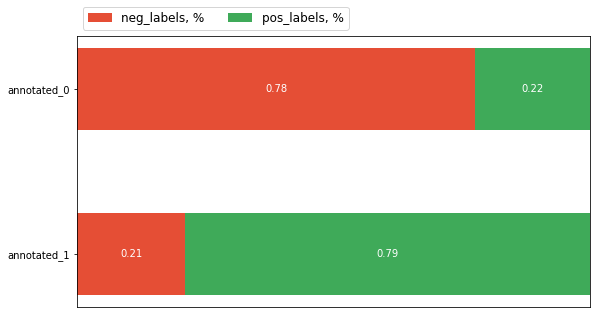

In [33]:
p_single_seed = ['ценить']
n_single_seed = ['ненавидеть']
plot_with_seeds(pd_df=df, threshold=-0.018, 
                p_seed=p_single_seed, n_seed=n_single_seed)

('neg_labels, %', 'pos_labels, %')


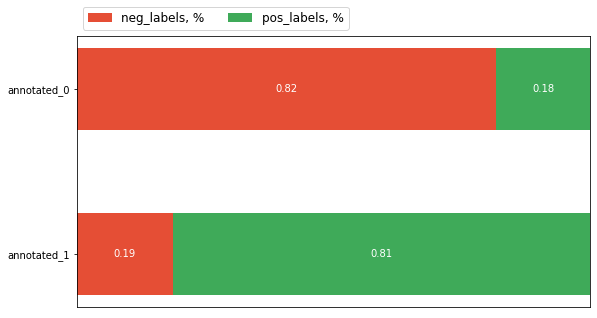

In [29]:
p_multi_seed = ['одобрять', 'хвалить', 'поощрять', 'любить']
n_multi_seed = ['ненавидеть', 'убить', 'ругать', 'злиться']

# for thres in np.arange(-0.2, 0.2, 0.001):
#     print(round(thres, 5))
for thres in [-0.007]:
    plot_with_seeds(pd_df=df, threshold=thres, 
                    p_seed=p_multi_seed, n_seed=n_multi_seed)
# -0.07

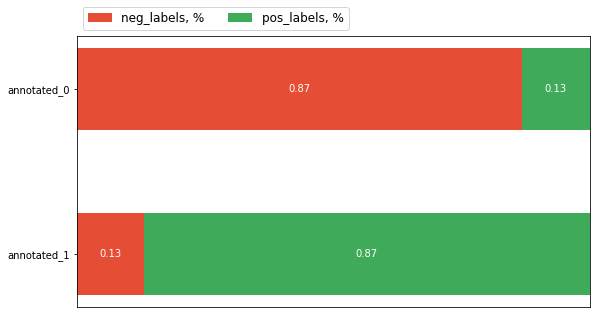

In [96]:
p_multi_seed = ['одобрять', 'хвалить', 'поощрять', 'любить',
                'обожать', 'восхищаться', 'восторгаться', 'гордиться',
                'ценить','превозносить',]
n_multi_seed = ['ненавидеть', 'ругать', 'злиться', 'порицать', 
                'осуждать', 'негодовать', 'обвинять', 'наказывать', 
                'убивать', 'разрушать',]

# for thres in np.arange(-0.2, 0.2, 0.001):
#     print(round(thres, 4))
for thres in [-0.049]:
    plot_with_seeds(pd_df=df, threshold=thres, 
                    p_seed=p_multi_seed, n_seed=n_multi_seed)

# -0.049

#Попытка расклассифицировать глаголы

In [0]:
where_csv_is = 'https://raw.githubusercontent.com/\
DmitryKutsev/NIS_SentiFrame/master/grouped_verb_lists/contrasting.csv'
cont_df = pd.read_csv(where_csv_is)
cont_df = cont_df[(cont_df['len'] == 1) &
                  ((cont_df['tag'] == 'INFN') | (cont_df['tag'] == 'VERB'))]

In [0]:
columns2drop = ['len', 'tag', 'a1_a3', 'author_a3', 'a2_a3']
cont_df.drop(columns2drop, axis=1, inplace=True)

In [218]:
cont_df[cont_df['a2_a2'].notna()]

,roles.a0,roles.a1,roles.a2,roles.a3,variant,key,a0_a1,a1_a2,a2_a1,author_a1,author_a2,a1_a0,a0_a2,author_a0,a2_a0,a0_a3,a2_a2,effect_a1,effect_a0,effect_a2,effect_a3,state_a0,state_a1,state_a2
593,кто повредил,кому повредил,что повредить,NaN,вредить,0_62,neg,NaN,NaN,NaN,NaN,neg,neg,NaN,NaN,NaN,pos,-,NaN,-,NaN,NaN,neg,NaN
595,кто повредил,кому повредил,что повредить,NaN,вывихивать,0_62,neg,NaN,NaN,NaN,NaN,neg,neg,NaN,NaN,NaN,pos,-,NaN,-,NaN,NaN,neg,NaN
596,кто повредил,кому повредил,что повредить,NaN,вывихнуть,0_62,neg,NaN,NaN,NaN,NaN,neg,neg,NaN,NaN,NaN,pos,-,NaN,-,NaN,NaN,neg,NaN
597,кто повредил,кому повредил,что повредить,NaN,загубить,0_62,neg,NaN,NaN,NaN,NaN,neg,neg,NaN,NaN,NaN,pos,-,NaN,-,NaN,NaN,neg,NaN
598,кто повредил,кому повредил,что повредить,NaN,запарывать,0_62,neg,NaN,NaN,NaN,NaN,neg,neg,NaN,NaN,NaN,pos,-,NaN,-,NaN,NaN,neg,NaN
599,кто повредил,кому повредил,что повредить,NaN,запороть,0_62,neg,NaN,NaN,NaN,NaN,neg,neg,NaN,NaN,NaN,pos,-,NaN,-,NaN,NaN,neg,NaN
600,кто повредил,кому повредил,что повредить,NaN,изувечивать,0_62,neg,NaN,NaN,NaN,NaN,neg,neg,NaN,NaN,NaN,pos,-,NaN,-,NaN,NaN,neg,NaN
601,кто повредил,кому повредил,что повредить,NaN,изувечить,0_62,neg,NaN,NaN,NaN,NaN,neg,neg,NaN,NaN,NaN,pos,-,NaN,-,NaN,NaN,neg,NaN
602,кто повредил,кому повредил,что повредить,NaN,изуродовать,0_62,neg,NaN,NaN,NaN,NaN,neg,neg,NaN,NaN,NaN,pos,-,NaN,-,NaN,NaN,neg,NaN
603,кто повредил,кому повредил,что повредить,NaN,исковеркать,0_62,neg,NaN,NaN,NaN,NaN,neg,neg,NaN,NaN,NaN,pos,-,NaN,-,NaN,NaN,neg,NaN


In [0]:
# cont_df.apply('nunique')
# groups = [
#           cont_df['roles.a3'].notna(),
#           cont_df['a0_a3'].notna(),         
# ]
# cont_df

In [0]:
%%capture
# at least two mutual pos/neg attitudes
!wget https://github.com/DmitryKutsev/NIS_SentiFrame/raw/master/grouped_verb_lists/verb_lists.zip
!unzip verb_lists.zip
# at least two opposite attitudes (only a0/a1 show opposite attitudes toward each other)
!wget https://raw.githubusercontent.com/DmitryKutsev/NIS_SentiFrame/master/grouped_verb_lists/opp_a0_a1_candidates_l.json

In [0]:
class_dict = {}
verbs_count = Counter()
for fname in listdir():
    if fname.endswith('.json'):
        with open (fname, 'r', encoding='utf-8') as f:
            verb_list = json.load(f)
            verbs_count.update(verb_list)
        class_dict.update({fname:verb_list})
# verbs_count.most_common(3)

In [0]:
verb2classes = {x:[] for x in verbs_count.keys()}
for fname in class_dict.keys():
    for verb in class_dict[fname]:
        verb2classes[verb].append(fname)
        if len(verb2classes[verb]) == 3:
            print(verb, verb2classes[verb])

In [0]:
for verb, va in verb2classes.items():
    if (len(va) > 1) and ('pos' in va) and ('neg' in va):
        print (verb, va)
# there are no such cases which is great

In [0]:
df['"Класс"'] = df['verb'].apply(lambda x: ' '.join(verb2classes[x]) if x in verb2classes.keys() else None)

In [75]:
multi_thr = -0.049
df['sg_multi_{}'.format(multi_thr)] = df['skipgram_axis_similarity'].apply(
    lambda x: 0 if x < multi_thr else 1)
groups = [
          df['"Класс"'],
          df['sg_multi_-0.049']
]
df.groupby(by=groups).agg('nunique')

verb  ...  sg_multi_-0.049
"Класс"                                            sg_multi_-0.049        ...                 
neg_a0_a1_mutual.json                              0                 150  ...                1
                                                   1                  14  ...                1
neg_a0_a1_mutual.json neg_a0_a1_mutual.json        0                  21  ...                1
                                                   1                   2  ...                1
neg_a0_a2_mutual.json                              0                   1  ...                1
neg_a0_a2_mutual.json neg_a0_a1_mutual.json        0                  12  ...                1
                                                   1                   1  ...                1
neg_a0_a2_mutual.json neg_a1_a2_mutual.json neg... 0                   1  ...                1
neg_a0_a2_mutual.json neg_a1_a2_mutual.json pos... 0                   3  ...                1
                                                   1                   1  ...                1
neg_a1_a2_mutual.json                              0                  10  ...                1
opp_a0_a1_candidates_l.json                        1                   1  ...                1
pos_a0_a1_mutual.json                              0                   7  ...                1
                                                   1                  53  ...                1
pos_a0_a1_mutual.json pos_a0_a1_mutual.json        1                   1  ...                1
pos_a0_a2_mutual.json pos_a0_a1_mutual.json        1                   3  ...                1
pos_a1_a2_mutual.json                              1                   3  ...                1

[17 rows x 6 columns]

#Наконец посмотрим в глаза этим злодеям

In [79]:
df[
   (df['"Класс"']=='neg_a0_a1_mutual.json')
   & (df['sg_multi_-0.049']==1)
]

,verb,annotation_polarity,Комментарий,"""Класс""",skipgram_axis_similarity,sg_multi_-0.049
128,мешать,0,NaN,neg_a0_a1_mutual.json,-0.036137,1
138,надоесть,0,NaN,neg_a0_a1_mutual.json,-0.048772,1
178,озаботить,0,NaN,neg_a0_a1_mutual.json,0.017433,1
181,опорочить,0,NaN,neg_a0_a1_mutual.json,-0.022554,1
202,отказать,0,NaN,neg_a0_a1_mutual.json,-0.012124,1
204,отказывать,0,NaN,neg_a0_a1_mutual.json,-0.022449,1
208,отпугивать,0,NaN,neg_a0_a1_mutual.json,0.018893,1
266,портить,0,NaN,neg_a0_a1_mutual.json,-0.034168,1
275,потеснить,0,NaN,neg_a0_a1_mutual.json,0.026907,1
284,пренебрегать,0,NaN,neg_a0_a1_mutual.json,0.050409,1


In [80]:
df[
   (df['"Класс"']=='neg_a0_a1_mutual.json neg_a0_a1_mutual.json')
   & (df['sg_multi_-0.049']==1)
]

,verb,annotation_polarity,Комментарий,"""Класс""",skipgram_axis_similarity,sg_multi_-0.049
199,отбить,0,NaN,neg_a0_a1_mutual.json neg_a0_a1_mutual.json,-0.035831,1
265,порочить,0,NaN,neg_a0_a1_mutual.json neg_a0_a1_mutual.json,-0.037538,1


In [81]:
df[
   (df['"Класс"']=='neg_a0_a2_mutual.json neg_a0_a1_mutual.json')
   & (df['sg_multi_-0.049']==1)
]

,verb,annotation_polarity,Комментарий,"""Класс""",skipgram_axis_similarity,sg_multi_-0.049
223,переть,0,NaN,neg_a0_a2_mutual.json neg_a0_a1_mutual.json,-0.001767,1


In [82]:
df[
   (df['"Класс"']=='neg_a0_a2_mutual.json neg_a1_a2_mutual.json pos_a0_a1_mutual.json')
   & (df['sg_multi_-0.049']==1)
] #NB!

,verb,annotation_polarity,Комментарий,"""Класс""",skipgram_axis_similarity,sg_multi_-0.049
371,спасти,1,NaN,neg_a0_a2_mutual.json neg_a1_a2_mutual.json po...,-0.024354,1


In [83]:
df[
   (df['"Класс"']=='pos_a0_a1_mutual.json')
   & (df['sg_multi_-0.049']==0)
]

,verb,annotation_polarity,Комментарий,"""Класс""",skipgram_axis_similarity,sg_multi_-0.049
39,вступиться,1,за,pos_a0_a1_mutual.json,-0.118186,0
46,вызволить,1,NaN,pos_a0_a1_mutual.json,-0.124878,0
96,заступиться,1,за,pos_a0_a1_mutual.json,-0.124154,0
100,защищать,1,NaN,pos_a0_a1_mutual.json,-0.067394,0
156,обезопасить,1,NaN,pos_a0_a1_mutual.json,-0.123709,0
171,объединиться,1,с,pos_a0_a1_mutual.json,-0.082214,0
255,помиловать,1,NaN,pos_a0_a1_mutual.json,-0.115612,0


#А также посмотрим в глаза тем, кого нам не удалось раскусить разметкой

In [84]:
groups = [
          df['annotation_polarity'],
          df['sg_multi_-0.049']
]
df.groupby(by=groups).agg('nunique')

verb  ...  sg_multi_-0.049
annotation_polarity sg_multi_-0.049        ...                 
0                   0                 279  ...                1
                    1                  43  ...                1
1                   0                  16  ...                1
                    1                 107  ...                1

[4 rows x 6 columns]

In [85]:
df[
   (df['annotation_polarity']==0)
   & (df['sg_multi_-0.049']==1)
]

,verb,annotation_polarity,Комментарий,"""Класс""",skipgram_axis_similarity,sg_multi_-0.049
16,велеть,0,NaN,None,-0.045856,1
44,выгореть,0,одноместный,None,-0.009381,1
87,запретить,0,NaN,None,-0.042074,1
97,затребовать,0,NaN,None,-0.013084,1
102,злоупотреблять,0,NaN,None,0.048760,1
118,исчерпать,0,NaN,None,0.016235,1
128,мешать,0,NaN,neg_a0_a1_mutual.json,-0.036137,1
136,навязывать,0,NaN,None,-0.009967,1
138,надоесть,0,NaN,neg_a0_a1_mutual.json,-0.048772,1
172,обязать,0,NaN,None,0.003923,1


In [86]:
df[
   (df['annotation_polarity']==1)
   & (df['sg_multi_-0.049']==0)
]

,verb,annotation_polarity,Комментарий,"""Класс""",skipgram_axis_similarity,sg_multi_-0.049
39,вступиться,1,за,pos_a0_a1_mutual.json,-0.118186,0
46,вызволить,1,NaN,pos_a0_a1_mutual.json,-0.124878,0
96,заступиться,1,за,pos_a0_a1_mutual.json,-0.124154,0
100,защищать,1,NaN,pos_a0_a1_mutual.json,-0.067394,0
129,модернизировать,1,NaN,None,-0.076977,0
130,молиться,1,NaN,None,-0.073942,0
156,обезопасить,1,NaN,pos_a0_a1_mutual.json,-0.123709,0
171,объединиться,1,с,pos_a0_a1_mutual.json,-0.082214,0
186,освободить,1,NaN,neg_a0_a2_mutual.json neg_a1_a2_mutual.json po...,-0.141749,0
187,освобождать,1,NaN,neg_a0_a2_mutual.json neg_a1_a2_mutual.json po...,-0.157574,0


#Ну и глянем, насколько согласуется наша разметка с экспертной (спойлер: достаточно хорошо)

In [0]:
groups = [
          df['annotation_polarity'],
          df['"Класс"']
]
df.groupby(by=groups).agg('nunique')

In [91]:
df[
   (df['annotation_polarity']==0)
   & (df['"Класс"']=='pos_a0_a1_mutual.json')
]

,verb,annotation_polarity,Комментарий,"""Класс""",skipgram_axis_similarity,sg_multi_-0.049
355,скрывать,0,NaN,pos_a0_a1_mutual.json,-0.011091,1
356,скрыть,0,NaN,pos_a0_a1_mutual.json,0.003973,1
377,спрятать,0,NaN,pos_a0_a1_mutual.json,0.021072,1


In [92]:
df[
   (df['annotation_polarity']==1)
   & (df['"Класс"']=='neg_a0_a2_mutual.json neg_a1_a2_mutual.json pos_a0_a1_mutual.json')
]

,verb,annotation_polarity,Комментарий,"""Класс""",skipgram_axis_similarity,sg_multi_-0.049
186,освободить,1,NaN,neg_a0_a2_mutual.json neg_a1_a2_mutual.json po...,-0.141749,0
187,освобождать,1,NaN,neg_a0_a2_mutual.json neg_a1_a2_mutual.json po...,-0.157574,0
369,спасать,1,NaN,neg_a0_a2_mutual.json neg_a1_a2_mutual.json po...,-0.089789,0
371,спасти,1,NaN,neg_a0_a2_mutual.json neg_a1_a2_mutual.json po...,-0.024354,1


In [95]:
df[
   (df['annotation_polarity']==1)
   & (df['"Класс"']=='opp_a0_a1_candidates_l.json')
]

,verb,annotation_polarity,Комментарий,"""Класс""",skipgram_axis_similarity,sg_multi_-0.049
278,похвастаться,1,NaN,opp_a0_a1_candidates_l.json,0.301054,1


#Есть глаголы, с которыми ничего не понятно

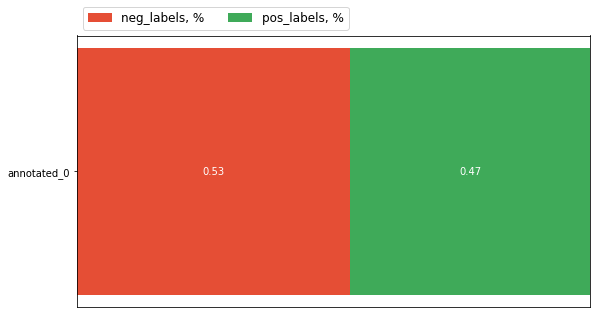

In [128]:
p_multi_seed = ['одобрять', 'хвалить', 'поощрять', 'любить',
                'обожать', 'восхищаться', 'восторгаться', 'гордиться',
                'ценить','превозносить',]
n_multi_seed = ['ненавидеть', 'ругать', 'злиться', 'порицать', 
                'осуждать', 'негодовать', 'обвинять', 'наказывать', 
                'убивать', 'разрушать',]
with open('opp_a0_a1_candidates_l.json', 'r', encoding='utf-8') as f:
    opp_list = json.load(f)
opp_list = [verb for verb in opp_list if (verb+'_VERB') in skipgram_model]
opp_df = pd.DataFrame({'verb':opp_list, 'annotation_polarity':[0 for verb in opp_list]})
# for thres in np.arange(-0.2, 0.2, 0.001):
    # print(round(thres, 4))
for thres in [0.143]:
    plot_with_seeds(pd_df=opp_df, threshold=thres, pols=1,
                    p_seed=p_multi_seed, n_seed=n_multi_seed) # -0.049

In [137]:
multi_thr = 0.143
opp_df['sg_multi_{}'.format(multi_thr)] = opp_df['skipgram_axis_similarity'].apply(
    lambda x: 0 if x < multi_thr else 1)
groups = [
          opp_df['sg_multi_{}'.format(multi_thr)],
          opp_df['verb']
]
opp_df.groupby(by=groups).agg('nunique')

verb  ...  sg_multi_0.1
sg_multi_0.143 verb                 ...              
0              взмолиться        1  ...             1
               вымаливать        1  ...             1
               вымолить          1  ...             1
               козырнуть         1  ...             1
               козырять          1  ...             1
               молить            1  ...             1
               похваляться       1  ...             1
               умолять           1  ...             1
1              бахвалиться       1  ...             1
               похвалиться       1  ...             1
               похвастаться      1  ...             1
               прихвастнуть      1  ...             1
               прихвастывать     1  ...             1
               хвалиться         1  ...             1
               хвастаться        1  ...             1

[15 rows x 8 columns]